# 1. Preprocessing

### Libraries

In [1]:
import os,sys
sys.path.append('..')
from _utils.BattLeDIM_utils import *

### Data loading

In [2]:
# import leak trajectory ground truth
path_ground_truth = '../_utils/Data/leak_ground_truth/2019_Leakages.csv'
df_leak_true, df_overview = load_trajectories_true(path_ground_truth)

# import leak trajectory detected
path_detections = '../_utils/Data/leak_detections/Leakages_detected.csv'
df_leak_det = load_trajectories_detected(path_detections)
df_leak_det = df_leak_det.drop(['p280','p277'], axis=1) # exclude DMA C leak

# 2. Analysis

### Detection based on z-scores (Sheward control charts)

In [3]:
t_zscore_est = 3 # time in days for mean/std estimation of each trajectory

df_overview_zscore = df_overview[df_leak_det.columns].copy()

df_traj = df_leak_det-df_leak_det.iloc[0,:] #start with zeros because condition for zscore > calc statistics from first non-zero value!
df_traj.index = pd.to_datetime(df_traj.index)    

z, ar_sigma, ar_mean = zscore(df_traj, int(t_zscore_est*12*24))  
df_z_score = z-z.iloc[0,:]

C_thr = 5

for i, pipe in enumerate(df_z_score):
    if any(df_z_score[pipe]>C_thr):
        leak_start = df_overview_zscore.loc['leak_start', pipe]
        leak_det = df_z_score.index[(df_z_score[pipe]>C_thr).values][0] 

        df_overview_zscore.loc['leak_det', pipe] = leak_det
        df_overview_zscore.loc['delta_t_det', pipe] = leak_det-leak_start
        df_overview_zscore.loc['delta_v_det', pipe] = df_leak_true[pipe].cumsum().loc[:leak_det][-2]/12

delta_t = df_overview_zscore.loc['delta_t_det'].dropna()
delta_t_avg = np.mean([j.total_seconds() for j in delta_t])/60/60/24 #sec to days
    
df_overview.loc['delta_t_zscore', df_overview_zscore.columns] = df_overview_zscore.loc['delta_t_det']
df_overview.loc['delta_v_zscore', df_overview_zscore.columns] = df_overview_zscore.loc['delta_v_det']
delta_v_avg = np.round(np.mean(df_overview_zscore.loc['delta_v_det']),2)

print(f'Average detection delay: {np.round(delta_t_avg,2)} (d)')
print(f'Average water loss before detection: {delta_v_avg} (m³)')

Average detection delay: 12.83 (d)
Average water loss before detection: 375.08 (m³)


### Detection based on Cusum-control-charts

In [4]:
t_zscore_est = 3 # time in days for mean/std estimation of each trajectory
delta = 4 # delta in cusum-formula (compare equation (1))

df_overview_cusum = df_overview[df_leak_det.columns].copy()

df_traj = df_leak_det-df_leak_det.iloc[0,:] #start with zeros because condition for zscore > calc statistics from first non-zero value!
df_traj.index = pd.to_datetime(df_traj.index)    

z, ar_sigma, ar_mean = zscore(df_traj, t_zscore_est*12*24) # estimation of sigma for each trajectory
ar_K = (delta/2)*ar_sigma
df_cusum = cusum(df_traj,ar_mean=ar_mean, ar_K=ar_K, direction='p')

C_thr = 5.8

for i, pipe in enumerate(df_cusum):
    C_thr_abs = C_thr*ar_sigma[i]
    if any(df_cusum[pipe]>C_thr_abs):
        leak_start = df_overview_cusum.loc['leak_start', pipe]
        leak_det = df_cusum.index[(df_cusum[pipe]>C_thr_abs).values][0]

        df_overview_cusum.loc['leak_det', pipe] = leak_det
        df_overview_cusum.loc['delta_t_det', pipe] = leak_det-leak_start
        df_overview_cusum.loc['delta_v_det', pipe] = df_leak_true[pipe].cumsum().loc[:leak_det][-2]/12

delta_t = [i for i in df_overview_cusum.loc['delta_t_det'].dropna()]
delta_t_avg = np.mean([j.total_seconds() for j in delta_t])/60/60/24 #sec to days
        
df_overview.loc['delta_t_cusum', df_overview_cusum.columns] = df_overview_cusum.loc['delta_t_det']
df_overview.loc['delta_v_cusum', df_overview_cusum.columns] = df_overview_cusum.loc['delta_v_det']
delta_v_avg = np.round(np.mean(df_overview_cusum.loc['delta_v_det']),2)

print(f'Average detection delay: {np.round(delta_t_avg,2)} (d)')
print(f'Average water loss before detection: {delta_v_avg} (m³)')

Average detection delay: 12.82 (d)
Average water loss before detection: 358.7 (m³)


### Overall method comparison

In [5]:
df_overview_T = df_overview[df_leak_det.columns].T
df_overview_T.insert(0, 'ID', [1,2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19])
df_overview_T 

,ID,leak_type,leak_start,leak_fix,delta_t_expert,delta_v_expert,delta_t_zscore,delta_v_zscore,delta_t_cusum,delta_v_cusum
p523,1,abrupt,2019-01-15 23:00:00,2019-02-01 09:50:00,0 days 00:00:00,0,0 days 00:00:00,0,0 days 00:00:00,0
p827,2,abrupt,2019-01-24 18:30:00,2019-02-07 09:05:00,0 days 00:00:00,0,0 days 00:00:00,0,0 days 00:00:00,0
p653,4,incipient,2019-03-03 13:10:00,2019-05-05 12:10:00,6 days 22:50:00,20.1833,15 days 18:35:00,235.807,17 days 20:40:00,342.102
p710,5,abrupt,2019-03-24 14:15:00,2019-12-31 23:55:00,0 days 00:05:00,0.460833,0 days 02:00:00,11.0583,0 days 02:05:00,11.5158
p514,6,abrupt,2019-04-02 20:40:00,2019-05-23 14:55:00,0 days 00:00:00,0,0 days 00:30:00,7.69417,0 days 00:25:00,6.4125
p331,7,abrupt,2019-04-20 10:10:00,2019-12-31 23:55:00,0 days 00:00:00,0,0 days 00:00:00,0,0 days 00:00:00,0
p193,9,incipient,2019-05-19 10:40:00,2019-12-31 23:55:00,13 days 08:15:00,43.8725,32 days 02:45:00,611.267,38 days 01:35:00,1017.44
p142,10,abrupt,2019-06-12 19:55:00,2019-07-17 09:25:00,0 days 00:00:00,0,0 days 00:00:00,0,0 days 00:05:00,2.20167
p680,11,abrupt,2019-07-10 08:45:00,2019-12-31 23:55:00,0 days 00:00:00,0,0 days 08:20:00,44.6667,0 days 01:25:00,7.59333
p586,12,incipient,2019-07-26 14:40:00,2019-09-16 03:20:00,5 days 09:50:00,24.0667,17 days 06:15:00,781.663,12 days 16:30:00,310.674


### Comparison of time to detection (TTD)

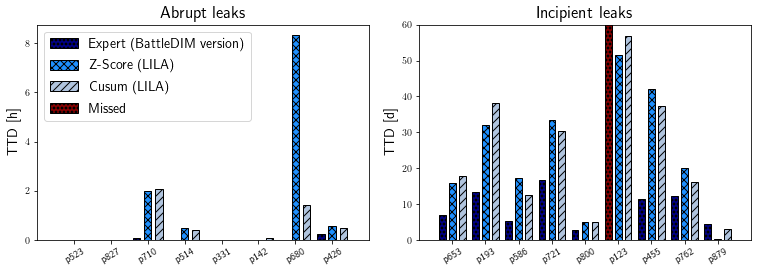

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10.75,4))
font = {'size'   : 14}
plt.rc('font', **font)

df_overview_abrupt = df_overview_T[df_overview_T['leak_type']=='abrupt']
df_overview_incipient = df_overview_T[df_overview_T['leak_type']=='incipient']

x_shift = 0.3
x_expert = np.subtract([i for i in range(len(df_overview_abrupt))],x_shift)
x_zscore = [i for i in range(len(df_overview_abrupt))]
x_cusum = np.add([i for i in range(len(df_overview_abrupt))],x_shift)#

ax[0].bar(-100, 1, width=0.38, hatch='ooo', color='darkblue', label='Expert (BattleDIM version)', edgecolor='black')
ax[0].bar(-100, 1, width=0.38, hatch='xxx', color='dodgerblue', label='Z-Score (LILA)', edgecolor='black')
ax[0].bar(-100, 1, width=0.38, hatch='///',color='lightsteelblue', label='Cusum (LILA)', edgecolor='black')
ax[0].bar(-100, 1, width=0.38, hatch='ooo', color='darkred', label='Missed', edgecolor='black')

ax[0].set_title('Abrupt leaks')
ax[0].bar(x_expert , [i.total_seconds()/3600 for i in df_overview_abrupt['delta_t_expert']], width=0.2, hatch='ooo', color='darkblue', edgecolor='black')
ax[0].bar(x_zscore , [i.total_seconds()/3600 for i in df_overview_abrupt['delta_t_zscore']], width=0.2, hatch='xxx', color='dodgerblue', edgecolor='black')
ax[0].bar(x_cusum, [i.total_seconds()/3600 for i in df_overview_abrupt['delta_t_cusum']], width=0.2, hatch='///', color='lightsteelblue', edgecolor='black')
ax[0].set_ylabel('TTD [h]', size=14)
ax[0].set_xticklabels(df_overview_abrupt.index, rotation=30)
ax[0].set_xticks([i for i in range(len(df_overview_abrupt))])
ax[0].set_xlim([-1,len(df_overview_abrupt['delta_t_cusum'].index)])
ax[0].legend(loc='upper left')

x_shift = 0.3
x_expert = np.subtract([i for i in range(len(df_overview_incipient))],x_shift)
x_zscore = [i for i in range(len(df_overview_incipient))]
x_cusum = np.add([i for i in range(len(df_overview_incipient))],x_shift)#

ax[1].set_title('Incipient leaks')
ax[1].bar(x_expert , [i.total_seconds()/3600/24 for i in df_overview_incipient['delta_t_expert']], width=0.2, hatch='ooo', color='darkblue', edgecolor='black')
plt.bar([5-x_shift] , [200], width=0.2, hatch='ooo', color='darkred', edgecolor='black') # missed annotation
ax[1].bar(x_zscore , [i.total_seconds()/3600/24 for i in df_overview_incipient['delta_t_zscore']], width=0.2, hatch='xxx', color='dodgerblue', edgecolor='black')
ax[1].bar(x_cusum, [i.total_seconds()/3600/24 for i in df_overview_incipient['delta_t_cusum']], width=0.2, hatch='///',color='lightsteelblue', edgecolor='black')
ax[1].set_ylabel('TTD [d]', size=14)
ax[1].set_xticklabels(df_overview_incipient.index, rotation=30)
ax[1].set_xticks([i for i in range(len(df_overview_incipient))],)
ax[1].set_xlim([-1,len(df_overview_incipient['delta_t_cusum'].index)])
ax[1].set_ylim([0,60])

plt.tight_layout()

### Comparison of volume leaked (V_leaked)

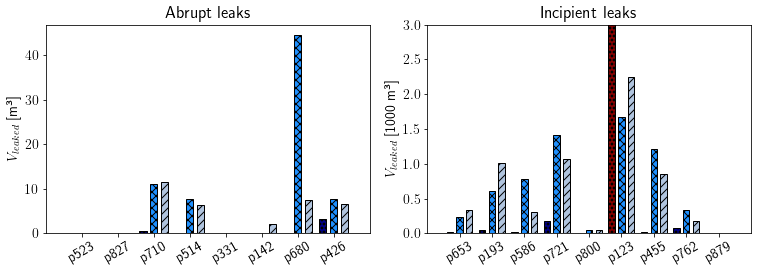

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10.75,4))

df_overview_abrupt = df_overview_T[df_overview_T['leak_type']=='abrupt']
df_overview_incipient = df_overview_T[df_overview_T['leak_type']=='incipient']

x_shift = 0.3
x_expert = np.subtract([i for i in range(len(df_overview_abrupt))],x_shift)
x_zscore = [i for i in range(len(df_overview_abrupt))]
x_cusum = np.add([i for i in range(len(df_overview_abrupt))],x_shift)

ax[0].set_title('Abrupt leaks')
ax[0].bar(x_expert , [i for i in df_overview_abrupt['delta_v_expert']], width=0.2, hatch='ooo', color='darkblue', edgecolor='black')
ax[0].bar(x_zscore , [i for i in df_overview_abrupt['delta_v_zscore']], width=0.2, hatch='xxx', color='dodgerblue', edgecolor='black')
ax[0].bar(x_cusum, [i for i in df_overview_abrupt['delta_v_cusum']], width=0.2, hatch='///', color='lightsteelblue', edgecolor='black')
ax[0].set_ylabel('$V_{leaked}$ [m³]', size=14)
ax[0].set_xticklabels(df_overview_abrupt.index, rotation=30)
ax[0].set_xticks([i for i in range(len(df_overview_abrupt))],)
ax[0].set_xlim([-1,len(df_overview_abrupt['delta_t_cusum'].index)])

x_shift = 0.3
x_expert = np.subtract([i for i in range(len(df_overview_incipient))],x_shift)
x_zscore = [i for i in range(len(df_overview_incipient))]
x_cusum = np.add([i for i in range(len(df_overview_incipient))],x_shift)#

ax[1].set_title('Incipient leaks')
ax[1].bar(x_expert , [i/1000 for i in df_overview_incipient['delta_v_expert']], width=0.2, hatch='ooo', color='darkblue', edgecolor='black')
plt.bar([5-x_shift] , [15000], width=0.2, hatch='ooo', color='darkred', edgecolor='black') # missed annotation
ax[1].bar(x_zscore , [i/1000 for i in df_overview_incipient['delta_v_zscore']], width=0.2, hatch='xxx', color='dodgerblue', edgecolor='black')
ax[1].bar(x_cusum, [i/1000 for i in df_overview_incipient['delta_v_cusum']], width=0.2, hatch='///',color='lightsteelblue', edgecolor='black')
ax[1].set_ylabel('$V_{leaked}$ [1000 m³]', size=14)
ax[1].set_xticklabels(df_overview_incipient.index, rotation=30)
ax[1].set_xticks([i for i in range(len(df_overview_incipient))],)
ax[1].set_xlim([-1,len(df_overview_incipient['delta_t_cusum'].index)])
ax[1].set_ylim([0,3])

plt.tight_layout()

### Saving of detection times

In [8]:
df_detection_times = pd.DataFrame(columns=['True', 'Expert (BDIM)', 'Z-Score (LILA)', 'Cusum (LILA)'])

df_detection_times['True'] = df_overview_T['leak_start']
df_detection_times['Expert (BDIM)'] = df_overview_T['leak_start']+ df_overview_T['delta_t_expert']
df_detection_times['Z-Score (LILA)'] = df_overview_T['leak_start']+ df_overview_T['delta_t_zscore']
df_detection_times['Cusum (LILA)'] = df_overview_T['leak_start']+ df_overview_T['delta_t_cusum']

df_detection_times.to_csv('../_utils/Data/leak_detections/detection_times_final.csv')
df_detection_times

,True,Expert (BDIM),Z-Score (LILA),Cusum (LILA)
p523,2019-01-15 23:00:00,2019-01-15 23:00:00,2019-01-15 23:00:00,2019-01-15 23:00:00
p827,2019-01-24 18:30:00,2019-01-24 18:30:00,2019-01-24 18:30:00,2019-01-24 18:30:00
p653,2019-03-03 13:10:00,2019-03-10 12:00:00,2019-03-19 07:45:00,2019-03-21 09:50:00
p710,2019-03-24 14:15:00,2019-03-24 14:20:00,2019-03-24 16:15:00,2019-03-24 16:20:00
p514,2019-04-02 20:40:00,2019-04-02 20:40:00,2019-04-02 21:10:00,2019-04-02 21:05:00
p331,2019-04-20 10:10:00,2019-04-20 10:10:00,2019-04-20 10:10:00,2019-04-20 10:10:00
p193,2019-05-19 10:40:00,2019-06-01 18:55:00,2019-06-20 13:25:00,2019-06-26 12:15:00
p142,2019-06-12 19:55:00,2019-06-12 19:55:00,2019-06-12 19:55:00,2019-06-12 20:00:00
p680,2019-07-10 08:45:00,2019-07-10 08:45:00,2019-07-10 17:05:00,2019-07-10 10:10:00
p586,2019-07-26 14:40:00,2019-08-01 00:30:00,2019-08-12 20:55:00,2019-08-08 07:10:00


# 3. Automated annotation of mass balance based leaks

### Data loading

In [9]:
# import leak trajectory ground truth
path_ground_truth = '../_utils/Data/leak_ground_truth/2019_Leakages.csv'
df_leak_true, df_overview = load_trajectories_true(path_ground_truth)
df_leak_true = df_leak_true[['p280','p277']]
df_overview = df_overview[['p280','p277']]

# import leak trajectory detected
path_detections = '../_utils/Data/leak_detections/Leakages_detected.csv'
df_leak_det = load_trajectories_detected(path_detections)
df_leak_det = df_leak_det[['p280','p277']] # select DMA C leak

### Detection based on z-scores (Sheward control charts)

In [10]:
t_zscore_est = 3 # time in days for mean/std estimation of each trajectory

df_overview_zscore = df_overview[df_leak_det.columns]

df_traj = df_leak_det[df_leak_det>0]
df_traj = df_traj-np.array([ 8.43309125, 13.93596241])  # normalize to zero mean before leak start
df_traj = df_traj.fillna(0)
df_traj.index = pd.to_datetime(df_traj.index) 

z, ar_sigma, ar_mean = zscore(df_traj, int(t_zscore_est*12*24))  
df_z_score = z-z.iloc[0,:]

C_thr = 5

for i, pipe in enumerate(df_z_score):
    if any(df_z_score[pipe]>C_thr):

        leak_start = df_overview_zscore.loc['leak_start', pipe]
        leak_det = df_z_score.index[(df_z_score[pipe]>C_thr).values][0] 

        df_overview_zscore.loc['leak_det', pipe] = leak_det
        df_overview_zscore.loc['delta_t_det', pipe] = leak_det-leak_start
        df_overview_zscore.loc['delta_v_det', pipe] = df_leak_true[pipe].cumsum().loc[:leak_det][-2]/12

delta_t = df_overview_zscore.loc['delta_t_det'].dropna()
delta_t_avg = np.mean([j.total_seconds() for j in delta_t])/60/60/24 #sec to days

df_overview.loc['delta_t_zscore', df_overview_zscore.columns] = df_overview_zscore.loc['delta_t_det']
df_overview.loc['delta_v_zscore', df_overview_zscore.columns] = df_overview_zscore.loc['delta_v_det']
delta_v_avg = np.round(np.mean(df_overview_zscore.loc['delta_v_det']),2)

print(f'Average detection delay: {np.round(delta_t_avg,2)} (d)')
print(f'Average water loss before detection: {delta_v_avg} (m³)')

Average detection delay: 14.27 (d)
Average water loss before detection: 133.15 (m³)


In [11]:
df_overview.T

,leak_type,leak_start,leak_fix,delta_t_expert,delta_v_expert,delta_t_zscore,delta_v_zscore
p280,abrupt,2019-02-10 13:05:00,2019-12-31 23:55:00,0 days 00:35:00,3.02083,0 days 02:45:00,14.2042
p277,incipient,2019-05-30 21:55:00,2019-12-31 23:55:00,-11 days +02:05:00,0,28 days 10:10:00,252.092
